# Восстановление золота из руды


Подготовим модель, которая  поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо предсказать коэффициент восстановления золота из золотосодержащей руды.


Данные находятся в трёх файлах:<br>
gold_recovery_train_new.csv — обучающая выборка;<br>
gold_recovery_test_new.csv — тестовая выборка;<br>
gold_recovery_full_new.csv — исходные данные.<br>

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, fbeta_score, make_scorer
import sweetviz as sv
from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import linear_model  

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    gold_recovery_full_new = pd.read_csv('/datasets/gold_recovery_full_new.csv') 
except:
    gold_recovery_full_new = pd.read_csv('C:\\Users\\User\\Downloads\\gold_recovery_full_new.csv')

In [3]:
try:
    gold_recovery_test_new = pd.read_csv('/datasets/gold_recovery_test_new.csv') 
except:
    gold_recovery_test_new = pd.read_csv('C:\\Users\\User\\Downloads\\gold_recovery_test_new.csv')

In [4]:
try:
    gold_recovery_train_new = pd.read_csv('/datasets/gold_recovery_train_new.csv') 
except:
    gold_recovery_train_new = pd.read_csv('C:\\Users\\User\\Downloads\\gold_recovery_train_new.csv')

In [5]:
full = sv.analyze([gold_recovery_full_new ,'gold_recovery_full'])
full.show_html('common analysis.html')

In [6]:
test = sv.analyze([gold_recovery_test_new ,'gold_recovery_test'])
test.show_html('common analysis.html')

In [7]:
train = sv.analyze([gold_recovery_train_new ,'gold_recovery_train'])
train.show_html('common analysis.html')

В исходных данных и обучающей выборке 87 признаков. В тестовой 53 колонки с прзнаками. Во всех выборках есть отсутствующие значения.


## Подготовка данных

Проверим правильность расчета эффективности обогащения на обучающей выборке.

$Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%$
*Где:*<br>
    - C — доля золота в концентрате после флотации/очистки;
    - F — доля золота в сырье/концентрате до флотации/очистки;
    - T — доля золота в отвальных хвостах после флотации/очистки.

In [8]:
# расчёт эффективности обогащения золота на этапе флотации
C = gold_recovery_train_new.loc[~gold_recovery_train_new['rougher.output.recovery'].isna(),
                                'rougher.output.concentrate_au']
F = gold_recovery_train_new.loc[~gold_recovery_train_new['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = gold_recovery_train_new.loc[~gold_recovery_train_new['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
recovery_calc = C * (F - T) / (F * (C - T)) * 100
recovery_train = gold_recovery_train_new.loc[~gold_recovery_train_new['rougher.output.recovery'].isna(),
                                                'rougher.output.recovery']

$sMAPE = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i| \div 2} \times 100\%$ - формула расчета симметричного среднего абсолютного процентного отклонения.

In [9]:
# расчёт sMAPE 
y_calc = abs(recovery_train - recovery_calc)
y_train = (abs(recovery_train) + abs(recovery_calc))/2
N = len(recovery_train)
smape_rough_rec = 1 / N * (y_calc / y_train).sum() * 100
print(smape_rough_rec)

1.1598012478556475e-14


Полученное значение sMAPE оказалось в достаточной степени маленьким, чтобы можно было утверждать, что параметр recovery посчитан верно. 

**Анализ параметров недоступных в тестовой выборке**

In [10]:
for column in gold_recovery_full_new.columns:
    if column not in gold_recovery_test_new.columns:
        print(column)  

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке отсутствуют параметры продукта output и расчётные характеристики calculation на всех этапах. Так же отсутствует целевой признак recovery.

***Предобработка данных***

Подготовим признаки, которых нет в тестовой выборке для удаления.

In [11]:
columns_to_drop = ["date", "final.output.concentrate_ag", 
     "final.output.concentrate_pb","final.output.concentrate_sol","final.output.concentrate_au",
"final.output.tail_ag","final.output.tail_pb","final.output.tail_sol","final.output.tail_au",
"primary_cleaner.output.concentrate_ag", "primary_cleaner.output.concentrate_pb",
"primary_cleaner.output.concentrate_sol", "primary_cleaner.output.concentrate_au", "primary_cleaner.output.tail_ag",
"primary_cleaner.output.tail_pb","primary_cleaner.output.tail_sol", "primary_cleaner.output.tail_au",
"rougher.calculation.sulfate_to_au_concentrate", "rougher.calculation.floatbank10_sulfate_to_au_feed",
"rougher.calculation.floatbank11_sulfate_to_au_feed", "rougher.calculation.au_pb_ratio","rougher.output.concentrate_ag",
"rougher.output.concentrate_pb", "rougher.output.concentrate_sol", "rougher.output.concentrate_au",
"rougher.output.tail_ag", "rougher.output.tail_pb", "rougher.output.tail_sol", "rougher.output.tail_au",
"secondary_cleaner.output.tail_ag", "secondary_cleaner.output.tail_pb", "secondary_cleaner.output.tail_sol",
"secondary_cleaner.output.tail_au"]

***Заполнение пропусков***

In [12]:
gold_recovery_train_new.isna().sum() # количество пропусков в train

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [13]:
gold_recovery_full_new.isna().sum() # количество пропусков в full

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [14]:
gold_recovery_test_new.isna().sum() # количество пропусков в test

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [15]:
# добавление recovery по дате
test_target = gold_recovery_test_new.merge(gold_recovery_full_new.loc[:,  
    ['date',"rougher.output.recovery","final.output.recovery"]],on = 'date')

In [16]:
# заполнение отсутствуюших значений предыдущими
gold_recovery_train_new = gold_recovery_train_new.fillna(method='ffill') 

In [17]:
#gold_recovery_full_new = gold_recovery_full_new.fillna(method='ffill')

In [18]:
# заполнение отсутствуюших значений предыдущими
test_target = test_target.fillna(method='ffill') 

Отсутствующие значения заполнены методом ffill по предыдущим значениям. Столбец recovery в тестовой выборке заполнен по значениям в колонке date по исходным данным.

## Анализ данных

Рассмотрим среднюю концентрацию металлов на каждом этапе очистки.

In [19]:
print("Средняя концентрация серебра после флотации:", gold_recovery_full_new["rougher.output.concentrate_ag"].mean())
print("Средняя концентрация серебра после первой очистки:",
      gold_recovery_full_new["primary_cleaner.output.concentrate_ag"].mean())
print("Средняя концентрация серебра после второй очистки:",
      gold_recovery_full_new["final.output.concentrate_ag"].mean())

Средняя концентрация серебра после флотации: 11.994759359873452
Средняя концентрация серебра после первой очистки: 8.442408077719056
Средняя концентрация серебра после второй очистки: 5.168470373676826


In [20]:
print("Средняя концентрация свинца после флотации:",gold_recovery_full_new["rougher.output.concentrate_pb"].mean()) 
print("Средняя концентрация свинца после первой очистки:",
      gold_recovery_full_new["primary_cleaner.output.concentrate_pb"].mean())               
print("Средняя концентрация свинца после второй очистки:",gold_recovery_full_new["final.output.concentrate_pb"].mean()) 

Средняя концентрация свинца после флотации: 7.606272313194984
Средняя концентрация свинца после первой очистки: 9.829529774200587
Средняя концентрация свинца после второй очистки: 9.978894911181714


In [21]:
print("Средняя концентрация золота после флотации:",gold_recovery_full_new["rougher.output.concentrate_au"].mean())
print("Средняя концентрация золота после первой очистки:",
      gold_recovery_full_new["primary_cleaner.output.concentrate_au"].mean())              
print("Средняя концентрация золота после второй очистки:",gold_recovery_full_new["final.output.concentrate_au"].mean())

Средняя концентрация золота после флотации: 19.772000139486334
Средняя концентрация золота после первой очистки: 32.1194004078766
Средняя концентрация золота после второй очистки: 44.076512941952664


Концентрация золота и свинца после каждого этапа очистки растет. Концентрация серебра падает.

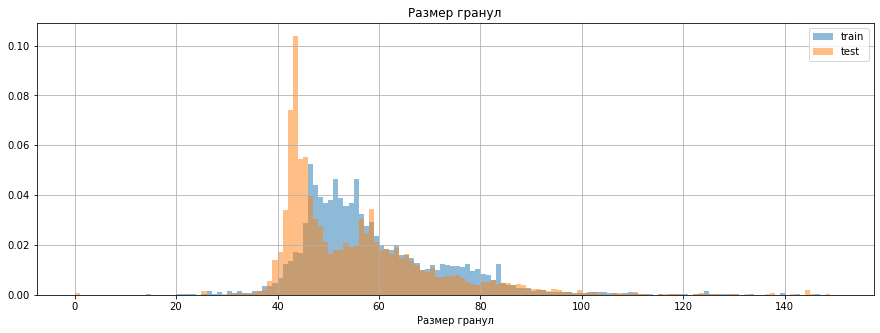

In [22]:
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.hist(gold_recovery_train_new["rougher.input.feed_size"], bins=150, range=(0, 150), alpha=0.5, density=True)
plt.hist(test_target["rougher.input.feed_size"], bins=150, range=(0, 150), alpha=0.5, density=True)
plt.legend(['train', 'test'])
plt.xlabel('Размер гранул')
plt.title('Размер гранул');

In [23]:
print('Средний размер гранул в обучающей выборке', gold_recovery_train_new["rougher.input.feed_size"].mean())
print('Средний размер гранул в тестовой выборке', test_target["rougher.input.feed_size"].mean())

Средний размер гранул в обучающей выборке 60.23985599255736
Средний размер гранул в тестовой выборке 55.95275402889511


Исследование суммарных концентраций веществ

In [24]:
gold_recovery_train_new['feed'] = gold_recovery_train_new['rougher.input.feed_ag'] +\
gold_recovery_train_new['rougher.input.feed_pb'] +gold_recovery_train_new['rougher.input.feed_sol'] +\
gold_recovery_train_new['rougher.input.feed_au']
gold_recovery_train_new['rougher'] = gold_recovery_train_new['rougher.output.concentrate_ag'] +\
gold_recovery_train_new['rougher.output.concentrate_pb'] + gold_recovery_train_new['rougher.output.concentrate_sol'] +\
gold_recovery_train_new['rougher.output.concentrate_au']
gold_recovery_train_new['final'] = gold_recovery_train_new['final.output.concentrate_ag'] +\
gold_recovery_train_new['final.output.concentrate_pb'] +gold_recovery_train_new['final.output.concentrate_sol'] +\
gold_recovery_train_new['final.output.concentrate_au']

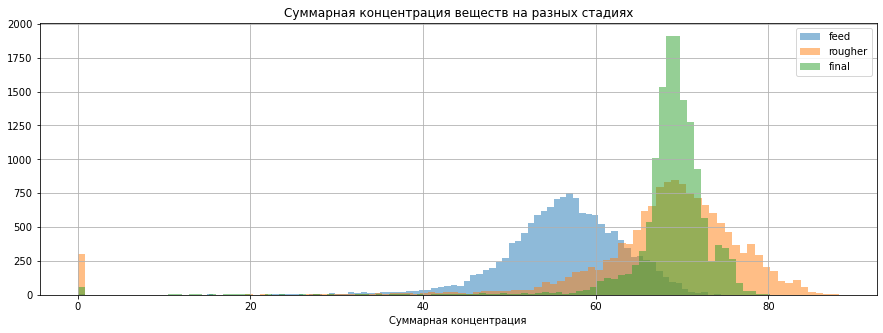

In [25]:
plt.figure(figsize=(15, 5)) # график суммарной концентрации веществ
plt.grid(True)
plt.hist(gold_recovery_train_new['feed'], bins=100, alpha=0.5)
plt.hist(gold_recovery_train_new['rougher'], bins=100, alpha=0.5)
plt.hist(gold_recovery_train_new['final'], bins=100, alpha=0.5)
plt.legend(['feed', 'rougher', 'final'])
plt.xlabel('Суммарная концентрация')
plt.title('Суммарная концентрация веществ на разных стадиях');

In [26]:
gold_recovery_train_new = gold_recovery_train_new[gold_recovery_train_new['feed'] > 20].copy()
gold_recovery_train_new = gold_recovery_train_new[gold_recovery_train_new['rougher'] > 20].copy()
gold_recovery_train_new = gold_recovery_train_new[gold_recovery_train_new['final'] > 20].copy()

Аномальными значениями являются значения около 0. Удалим значения меньше 20 из тренировочной выборки.

## Модель

In [27]:
# признаки для тестовой выборки
test_target_features = test_target.drop(["rougher.output.recovery","final.output.recovery"], axis=1)     
test_target_rougher = test_target["rougher.output.recovery"] # целевой признак для тестовой выборки
test_target_final = test_target["final.output.recovery"] # целевой признак для тестовой выборки

In [28]:
test_target_features = test_target_features.drop('date', axis=1) # удаление столбца date

In [29]:
# признаки для обучающей выборки
gold_recovery_train = gold_recovery_train_new.drop(["rougher.output.recovery","final.output.recovery"], axis=1)      
train_target_rougher = gold_recovery_train_new["rougher.output.recovery"] # целевой признак для обучающей выборки
train_target_final = gold_recovery_train_new["final.output.recovery"] # целевой признак для обучающей выборки

In [30]:
# удаление признаков отсутствующих в тестовой выборке
gold_recovery_train = gold_recovery_train.drop(columns_to_drop, axis = 1)

In [31]:
# удаление вспомогательных столбцов
gold_recovery_train = gold_recovery_train.drop(["feed","rougher","final"], axis=1) 

In [32]:
# формула расчета симметричного среднего абсолютного процентного отклонения
def sMAPE(target_true,target_pred):
    error = np.mean(abs(target_true - target_pred)/((abs(target_true)+abs(target_pred))/2))*100
    return error

In [33]:
def final_sMAPE(sMAPE_rougher,sMAPE_final): # итоговое sMAPE
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

**Обучим три модели: RandomForestRegressor, LinearRegression, linear_model.Lasso.**

In [34]:
model_2 = make_pipeline(StandardScaler(),LinearRegression())
model_3 = make_pipeline(StandardScaler(),linear_model.Lasso())

In [35]:
model_rf =RandomForestRegressor()

In [36]:
scorer = make_scorer(sMAPE,greater_is_better=True)

In [37]:
parametrs = { 'n_estimators': range (10, 21, 10),   # параметры для поиска лучшей модели
              'max_depth': range (1, 5, 2),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,5,2),
            }

In [38]:
grid = GridSearchCV(model_rf, parametrs, cv=5, scoring=scorer)   
grid.fit(gold_recovery_train, train_target_rougher)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 5, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 5, 2),
                         'n_estimators': range(10, 21, 10)},
             scoring=make_scorer(sMAPE))

In [39]:
grid.best_params_   # выводим результат с лучшими параметрами

{'max_depth': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 20}

{'max_depth': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 20}

In [40]:
model_1 = RandomForestRegressor(max_depth = 1, min_samples_leaf = 4, min_samples_split = 4, n_estimators = 20)

RandomForestRegressor

In [41]:
scorer = make_scorer(sMAPE,greater_is_better=True)
cv_rougher = cross_val_score(model_1, gold_recovery_train, train_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_1, gold_recovery_train, train_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

9.056312281219329


LinearRegression

In [42]:
cv_rougher = cross_val_score(model_2, gold_recovery_train, train_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_2, gold_recovery_train, train_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

9.957734217229937


Linear_model.Lasso   

In [43]:
scorer = make_scorer(sMAPE,greater_is_better=True)
cv_rougher = cross_val_score(model_3, gold_recovery_train, train_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_3, gold_recovery_train, train_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

8.62339468013344


CatBoostRegressor

In [44]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=1)

In [45]:
scorer = make_scorer(sMAPE,greater_is_better=True)
cv_rougher = cross_val_score(cat, gold_recovery_train, train_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(cat, gold_recovery_train, train_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

0:	learn: 6.4112568	total: 129ms	remaining: 129ms
1:	learn: 5.9292051	total: 132ms	remaining: 0us
0:	learn: 6.9219441	total: 3.87ms	remaining: 3.87ms
1:	learn: 6.4475700	total: 7.43ms	remaining: 0us
0:	learn: 7.4066388	total: 4.36ms	remaining: 4.36ms
1:	learn: 6.6065235	total: 11.6ms	remaining: 0us
0:	learn: 7.1558518	total: 3.6ms	remaining: 3.6ms
1:	learn: 6.5966596	total: 6.83ms	remaining: 0us
0:	learn: 6.8165511	total: 14.2ms	remaining: 14.2ms
1:	learn: 6.2892247	total: 18.8ms	remaining: 0us
0:	learn: 8.5464669	total: 3.26ms	remaining: 3.26ms
1:	learn: 8.2325905	total: 6.57ms	remaining: 0us
0:	learn: 8.9048553	total: 3.29ms	remaining: 3.29ms
1:	learn: 8.5881533	total: 6.25ms	remaining: 0us
0:	learn: 8.5658286	total: 3.31ms	remaining: 3.31ms
1:	learn: 8.2036987	total: 6.55ms	remaining: 0us
0:	learn: 8.4960321	total: 4.29ms	remaining: 4.29ms
1:	learn: 8.1353995	total: 8.55ms	remaining: 0us
0:	learn: 8.3490401	total: 11.4ms	remaining: 11.4ms
1:	learn: 8.0720490	total: 21.4ms	remaining:

**Проверим модели на тестовой выборке.**

In [46]:
cv_rougher = cross_val_score(model_2, test_target_features, test_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_2, test_target_features, test_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

11.062478377344835


In [47]:
cv_rougher = cross_val_score(model_1, test_target_features, test_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_1, test_target_features, test_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

9.67881932783447


In [48]:
cv_rougher = cross_val_score(model_3, test_target_features, test_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(model_3, test_target_features, test_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

9.086901048544291


In [49]:
scorer = make_scorer(sMAPE,greater_is_better=True)
cv_rougher = cross_val_score(cat, test_target_features, test_target_rougher, cv=5, scoring=scorer).mean()
cv_final = cross_val_score(cat, test_target_features, test_target_final, cv=5, scoring=scorer).mean()
result = final_sMAPE(cv_rougher, cv_final)
print(result)

0:	learn: 8.8152094	total: 2.37ms	remaining: 2.37ms
1:	learn: 8.5611919	total: 6.05ms	remaining: 0us
0:	learn: 12.3863817	total: 3.13ms	remaining: 3.13ms
1:	learn: 12.1543262	total: 5.39ms	remaining: 0us
0:	learn: 12.9266829	total: 2.62ms	remaining: 2.62ms
1:	learn: 12.6463359	total: 4.51ms	remaining: 0us
0:	learn: 12.7932126	total: 1.93ms	remaining: 1.93ms
1:	learn: 12.4319636	total: 4.71ms	remaining: 0us
0:	learn: 11.8151950	total: 2.1ms	remaining: 2.1ms
1:	learn: 11.5638692	total: 3.9ms	remaining: 0us
0:	learn: 9.3647442	total: 1.85ms	remaining: 1.85ms
1:	learn: 9.1364311	total: 3.63ms	remaining: 0us
0:	learn: 9.3808209	total: 1.93ms	remaining: 1.93ms
1:	learn: 9.1136041	total: 3.7ms	remaining: 0us
0:	learn: 9.3528571	total: 3.58ms	remaining: 3.58ms
1:	learn: 9.1128664	total: 7.28ms	remaining: 0us
0:	learn: 9.1389711	total: 1.91ms	remaining: 1.91ms
1:	learn: 8.8780912	total: 3.81ms	remaining: 0us
0:	learn: 8.3598711	total: 1.85ms	remaining: 1.85ms
1:	learn: 8.1168834	total: 3.58ms	r

Лучший результат показывает Linear_model.Lasso.

Проверим на константной модели.

In [50]:
rougher_dummy = DummyRegressor(strategy="median")
final_dummy= DummyRegressor(strategy="median")

In [51]:
rougher_dummy.fit(gold_recovery_train, train_target_rougher)
final_dummy.fit(gold_recovery_train, train_target_final)
predict_rougher = rougher_dummy.predict(test_target_rougher)
predict_final = final_dummy.predict(test_target_final)

In [52]:
final_sMAPE(sMAPE(test_target_rougher,predict_rougher),sMAPE(test_target_final,predict_final))

9.441911631456728

Ошибка на тестовой выборке для модели Linear_model.Lasso меньше, чем у константной модели

- Эффективность обогащения на обучающей выборке для признака rougher.output.recovery. расчитана правильно. 
- Проанализированы концентрации металлов (Au, Ag, Pb) на всех стадиях очистки. Концентрация золота и свинца после каждого этапа очистки растет. Концентрация серебра падает.
- Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок.
- При исследовании суммарных концентраций веществ на разных стадиях очистки подтвердилось наличие аномальных данных. Все объекты с суммарной концентрацией меньше 20 были удалены из тренировочной выборки.
- Удалены признаки недоступные с тестовой выборке.
- Данные обучены на моделях CatBoostRegressor, Lasso, RandomForestRegressor, LinearRegression.
Лучшее значение sMAPE показала модель Lasso на тестовой выборке: 9.08% <br>
Константная модель - 9.44%.